In [14]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [76]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Path to your dataset
dataset_dir = "DLPROJECTDATASET" 

# Helper function to create a DataFrame from the class directories
def create_dataframe_from_directory(directory):
    filepaths = []
    labels = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                filepaths.append(os.path.join(class_dir, file))
                labels.append(label)  # Folder name as the label
    return pd.DataFrame({"filepaths": filepaths, "labels": labels})

# Create a single DataFrame for all the data
data = create_dataframe_from_directory(dataset_dir)

# Split data into train, validation, and test sets
train_set, temp_set = train_test_split(data, test_size=0.3, stratify=data['labels'], random_state=42)
val_set, test_images = train_test_split(temp_set, test_size=0.5, stratify=temp_set['labels'], random_state=42)

# Shuffle the training set
train_set = train_set.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the number of samples in each set
print(f"Training samples: {len(train_set)}")
print(f"Validation samples: {len(val_set)}")
print(f"Testing samples: {len(test_images)}")


Training samples: 767
Validation samples: 165
Testing samples: 165


In [77]:
# # Preprocessing with Resnet preprocessing function
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)


Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


In [79]:
def create_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ])
    return model

def create_advanced_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ])
    return model
def create_hybrid_model(input_shape, num_classes):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Use ResNet as a feature extractor

    model = Sequential([
        base_model,
        # Additional convolutional layers after ResNet
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),
        GlobalAveragePooling2D(),

        # Fully connected layers
        Dense(128, activation="relu"),
        Dropout(0.5),

        Dense(num_classes, activation="softmax"),
    ])
    return model


model_save_dir = "./models"
os.makedirs(model_save_dir, exist_ok=True)
# Train and evaluate models
results = {}
trained_models = {}

model_architectures = {
  "BasicCNN": create_cnn,
"Advanced_CNN":create_advanced_cnn,
"ResNet50": create_hybrid_model
    
}


for model_name, create_model in model_architectures.items():
    print(f"Training {model_name}...")
    base_model = create_model((224, 224, 3), len(train.class_indices))

    # Compile the base model
    base_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the base model
    history = base_model.fit(train, validation_data=val, epochs=30, callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ])

    # Save the model
    base_model.save(os.path.join(model_save_dir, f"{model_name}.h5"))
    trained_models[model_name] = base_model

    # Evaluate on validation set
    val_loss, val_accuracy = base_model.evaluate(val)
    results[model_name] = {"accuracy": val_accuracy, "loss": val_loss, "history": history}

# Evaluate individual models
for model_name, model in trained_models.items():
    preds = model.predict(val)
    y_pred = preds.argmax(axis=1)
    y_true = val.classes
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(y_true, y_pred))



Training ResNet50...
Epoch 1/30
24/24 [==============================] - 99s 4s/step - loss: 0.6192 - accuracy: 0.7510 - val_loss: 0.3241 - val_accuracy: 0.8667
Epoch 2/30
24/24 [==============================] - 84s 4s/step - loss: 0.3100 - accuracy: 0.8761 - val_loss: 0.2784 - val_accuracy: 0.8727
Epoch 3/30
24/24 [==============================] - 82s 3s/step - loss: 0.2152 - accuracy: 0.9140 - val_loss: 0.1891 - val_accuracy: 0.9273
Epoch 4/30
24/24 [==============================] - 84s 4s/step - loss: 0.1119 - accuracy: 0.9570 - val_loss: 0.2273 - val_accuracy: 0.9273
Epoch 5/30
24/24 [==============================] - 84s 4s/step - loss: 0.0672 - accuracy: 0.9739 - val_loss: 0.0954 - val_accuracy: 0.9758
Epoch 6/30
24/24 [==============================] - 86s 4s/step - loss: 0.0278 - accuracy: 0.9909 - val_loss: 0.2701 - val_accuracy: 0.9273
Epoch 7/30
24/24 [==============================] - 85s 4s/step - loss: 0.0725 - accuracy: 0.9713 - val_loss: 0.1176 - val_accuracy: 0.9576

In [96]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Directory where models are saved
model_save_dir = "./models"

# Load all models from the directory
loaded_models = {}
for file in os.listdir(model_save_dir):
    if file.endswith(".h5"):
        model_name = file.split(".h5")[0]
        loaded_models[model_name] = load_model(os.path.join(model_save_dir, file))
        print(f"Loaded {model_name} model.")

# Evaluate each model and collect metrics
metrics = {}
for model_name, model in loaded_models.items():
    print(f"\nEvaluating {model_name}...")
    preds = model.predict(val)
    y_pred = preds.argmax(axis=1)
    y_true = val.classes

    # Classification Report
    report = classification_report(y_true, y_pred, output_dict=True)
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix for {model_name}:\n", cm)
    
    # Additional Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"Metrics Summary for {model_name}:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision (Weighted): {precision:.4f}")
    print(f"  - Recall (Weighted): {recall:.4f}")
    print(f"  - F1-Score (Weighted): {f1:.4f}")
    
    # Save metrics for later use
    metrics[model_name] = {
        "y_true": y_true,
        "y_pred": y_pred,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Ensemble Predictions
def ensemble_predictions(models, val_data):
    ensemble_preds = None
    for model in models.values():
        preds = model.predict(val_data)
        ensemble_preds = preds if ensemble_preds is None else ensemble_preds + preds
    return ensemble_preds / len(models)

print("\nCalculating Ensemble Predictions...")
ensemble_preds = ensemble_predictions(loaded_models, val)
ensemble_y_pred = ensemble_preds.argmax(axis=1)

# Evaluate ensemble
ensemble_accuracy = accuracy_score(y_true, ensemble_y_pred)
ensemble_precision = precision_score(y_true, ensemble_y_pred, average="weighted")
ensemble_recall = recall_score(y_true, ensemble_y_pred, average="weighted")
ensemble_f1 = f1_score(y_true, ensemble_y_pred, average="weighted")

print("\nEnsemble Classification Report:\n", classification_report(y_true, ensemble_y_pred))
print("\nEnsemble Confusion Matrix:\n", confusion_matrix(y_true, ensemble_y_pred))
print(f"\nEnsemble Performance Metrics:")
print(f"  - Accuracy: {ensemble_accuracy:.4f}")
print(f"  - Precision (Weighted): {ensemble_precision:.4f}")
print(f"  - Recall (Weighted): {ensemble_recall:.4f}")
print(f"  - F1-Score (Weighted): {ensemble_f1:.4f}")



Loaded Advanced_CNN model.
Loaded BasicCNN model.
Loaded ResNet50 model.

Evaluating Advanced_CNN...
6/6 [==============================] - 2s 336ms/step
Classification Report for Advanced_CNN:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       1.00      1.00      1.00        84
           2       0.97      0.95      0.96        63

    accuracy                           0.97       165
   macro avg       0.94      0.95      0.94       165
weighted avg       0.97      0.97      0.97       165

Confusion Matrix for Advanced_CNN:
 [[16  0  2]
 [ 0 84  0]
 [ 3  0 60]]
Metrics Summary for Advanced_CNN:
  - Accuracy: 0.9697
  - Precision (Weighted): 0.9705
  - Recall (Weighted): 0.9697
  - F1-Score (Weighted): 0.9700

Evaluating BasicCNN...
6/6 [==============================] - 2s 234ms/step
Classification Report for BasicCNN:
               precision    recall  f1-score   support

           0       1.00      0.9

In [87]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Directory containing saved models
model_save_dir = "./models"

# Load models and evaluate them
test_metrics = {}
loaded_models = {}

# Load and evaluate each model
for model_name in os.listdir(model_save_dir):
    if model_name.endswith(".h5"):
        model_path = os.path.join(model_save_dir, model_name)
        model = load_model(model_path)
        loaded_models[model_name] = model

        print(f"Evaluating {model_name} on the test set...")
        preds = model.predict(test, steps=len(test), verbose=1)
        y_pred = np.argmax(preds, axis=1)
        y_true = test.classes

        # Classification report
        print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
        
        # Confusion matrix
        print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(y_true, y_pred))

        # Metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average="weighted")
        recall = recall_score(y_true, y_pred, average="weighted")
        f1 = f1_score(y_true, y_pred, average="weighted")

        print(f"Metrics Summary for {model_name}:")
        print(f"  - Accuracy: {accuracy:.4f}")
        print(f"  - Precision (Weighted): {precision:.4f}")
        print(f"  - Recall (Weighted): {recall:.4f}")
        print(f"  - F1-Score (Weighted): {f1:.4f}\n")

        # Save metrics
        test_metrics[model_name] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

# Perform ensemble prediction on the test set
print("\nPerforming ensemble prediction on the test set...")

ensemble_preds = None
for model_name, model in loaded_models.items():
    preds = model.predict(test, steps=len(test), verbose=1)
    if ensemble_preds is None:
        ensemble_preds = preds
    else:
        ensemble_preds += preds

# Average predictions
ensemble_preds /= len(loaded_models)
ensemble_y_pred = np.argmax(ensemble_preds, axis=1)
y_true = test.classes

# Ensemble metrics
ensemble_accuracy = accuracy_score(y_true, ensemble_y_pred)
ensemble_precision = precision_score(y_true, ensemble_y_pred, average="weighted")
ensemble_recall = recall_score(y_true, ensemble_y_pred, average="weighted")
ensemble_f1 = f1_score(y_true, ensemble_y_pred, average="weighted")

print("\nEnsemble Metrics Summary:")
print(f"  - Accuracy: {ensemble_accuracy:.4f}")
print(f"  - Precision (Weighted): {ensemble_precision:.4f}")
print(f"  - Recall (Weighted): {ensemble_recall:.4f}")
print(f"  - F1-Score (Weighted): {ensemble_f1:.4f}\n")


Evaluating Advanced_CNN.h5 on the test set...
6/6 [==============================] - 3s 366ms/step
Classification Report for Advanced_CNN.h5:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.99      1.00      0.99        85
           2       0.98      1.00      0.99        62

    accuracy                           0.99       165
   macro avg       0.99      0.96      0.98       165
weighted avg       0.99      0.99      0.99       165

Confusion Matrix for Advanced_CNN.h5:
 [[16  1  1]
 [ 0 85  0]
 [ 0  0 62]]
Metrics Summary for Advanced_CNN.h5:
  - Accuracy: 0.9879
  - Precision (Weighted): 0.9880
  - Recall (Weighted): 0.9879
  - F1-Score (Weighted): 0.9876

Evaluating BasicCNN.h5 on the test set...
6/6 [==============================] - 2s 278ms/step
Classification Report for BasicCNN.h5:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
  

In [88]:
import numpy as np

# Helper function to save ImageDataGenerator data
def save_image_gen_data(generator, save_dir, dataset_name):
    """
    Save the preprocessed images and labels from an ImageDataGenerator iterator.

    Args:
        generator: The ImageDataGenerator iterator (e.g., train, val, test).
        save_dir: Directory to save the NumPy arrays.
        dataset_name: Name of the dataset ('train', 'val', 'test').

    Saves:
        - {save_dir}/{dataset_name}_images.npy
        - {save_dir}/{dataset_name}_labels.npy
    """
    images = []
    labels = []
    for _ in range(len(generator)):
        x_batch, y_batch = generator.next()
        images.append(x_batch)
        labels.append(y_batch)

    # Concatenate all batches
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    # Save to disk
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, f"{dataset_name}_images.npy"), images)
    np.save(os.path.join(save_dir, f"{dataset_name}_labels.npy"), labels)
    print(f"Saved {dataset_name} data to {save_dir}.")

# Save train, val, and test data
save_dir = "./saved_data"
save_image_gen_data(train, save_dir, "train")
save_image_gen_data(val, save_dir, "val")
save_image_gen_data(test, save_dir, "test")


Saved train data to ./saved_data.
Saved val data to ./saved_data.
Saved test data to ./saved_data.


In [89]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load the saved test data
save_dir = "./saved_data"
test_images = np.load(os.path.join(save_dir, "test_images.npy"))
test_labels = np.load(os.path.join(save_dir, "test_labels.npy"))

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Path to saved models
model_dir = "./models"
model_files = [file for file in os.listdir(model_dir) if file.endswith(".h5")]

# Initialize dictionaries to store results
test_metrics = {}
ensemble_preds = None

# Evaluate each model on the test set
for model_file in model_files:
    model_name = model_file.split(".h5")[0]
    print(f"\nEvaluating {model_name} on the test set...")
    
    # Load the model
    model_path = os.path.join(model_dir, model_file)
    model = load_model(model_path)
    
    # Predict on the test set
    preds = model.predict(test_images)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(test_labels, axis=1)

    # Combine predictions for ensemble
    if ensemble_preds is None:
        ensemble_preds = preds
    else:
        ensemble_preds += preds

    # Classification report
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    
    # Confusion matrix
    print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(y_true, y_pred))
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    
    print(f"Metrics Summary for {model_name}:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision (Weighted): {precision:.4f}")
    print(f"  - Recall (Weighted): {recall:.4f}")
    print(f"  - F1-Score (Weighted): {f1:.4f}\n")
    
    # Store metrics
    test_metrics[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Perform ensemble prediction on the test set
print("\nPerforming ensemble prediction on the test set...")
ensemble_preds /= len(model_files)  # Average the predictions
ensemble_y_pred = np.argmax(ensemble_preds, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Ensemble metrics
ensemble_accuracy = accuracy_score(y_true, ensemble_y_pred)
ensemble_precision = precision_score(y_true, ensemble_y_pred, average="weighted")
ensemble_recall = recall_score(y_true, ensemble_y_pred, average="weighted")
ensemble_f1 = f1_score(y_true, ensemble_y_pred, average="weighted")

print("\nEnsemble Metrics Summary:")
print(f"  - Accuracy: {ensemble_accuracy:.4f}")
print(f"  - Precision (Weighted): {ensemble_precision:.4f}")
print(f"  - Recall (Weighted): {ensemble_recall:.4f}")
print(f"  - F1-Score (Weighted): {ensemble_f1:.4f}\n")


Test images shape: (165, 224, 224, 3)
Test labels shape: (165, 3)

Evaluating Advanced_CNN on the test set...
6/6 [==============================] - 3s 411ms/step
Classification Report for Advanced_CNN:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.99      1.00      0.99        85
           2       0.98      1.00      0.99        62

    accuracy                           0.99       165
   macro avg       0.99      0.96      0.98       165
weighted avg       0.99      0.99      0.99       165

Confusion Matrix for Advanced_CNN:
 [[16  1  1]
 [ 0 85  0]
 [ 0  0 62]]
Metrics Summary for Advanced_CNN:
  - Accuracy: 0.9879
  - Precision (Weighted): 0.9880
  - Recall (Weighted): 0.9879
  - F1-Score (Weighted): 0.9876


Evaluating BasicCNN on the test set...
6/6 [==============================] - 2s 295ms/step
Classification Report for BasicCNN:
               precision    recall  f1-score   support

      

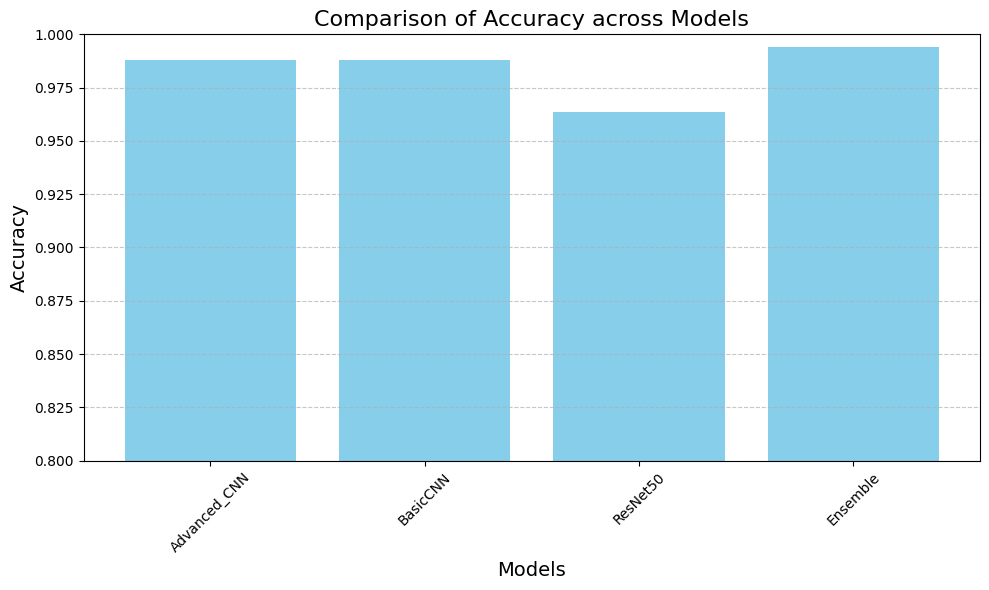

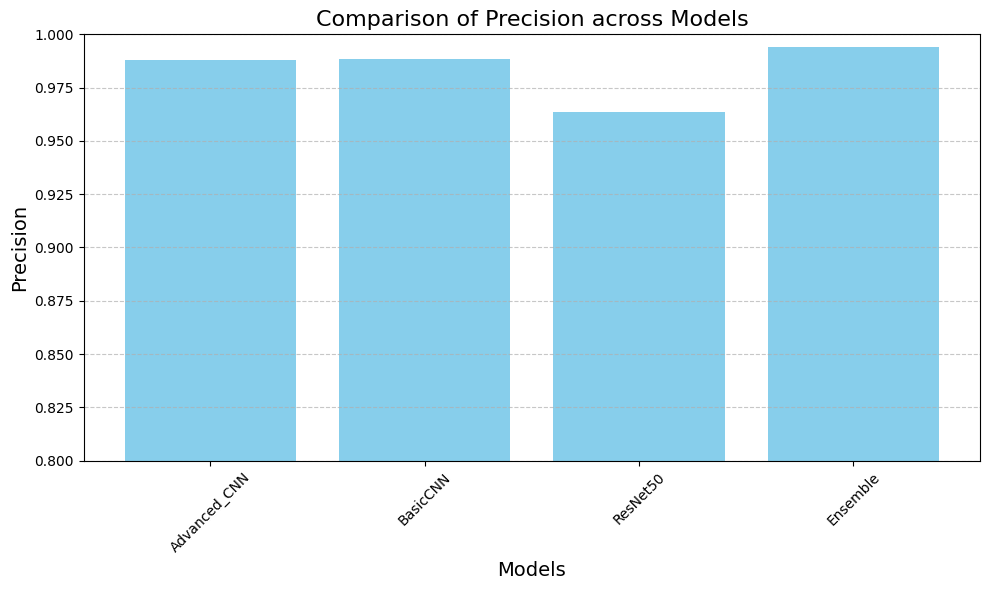

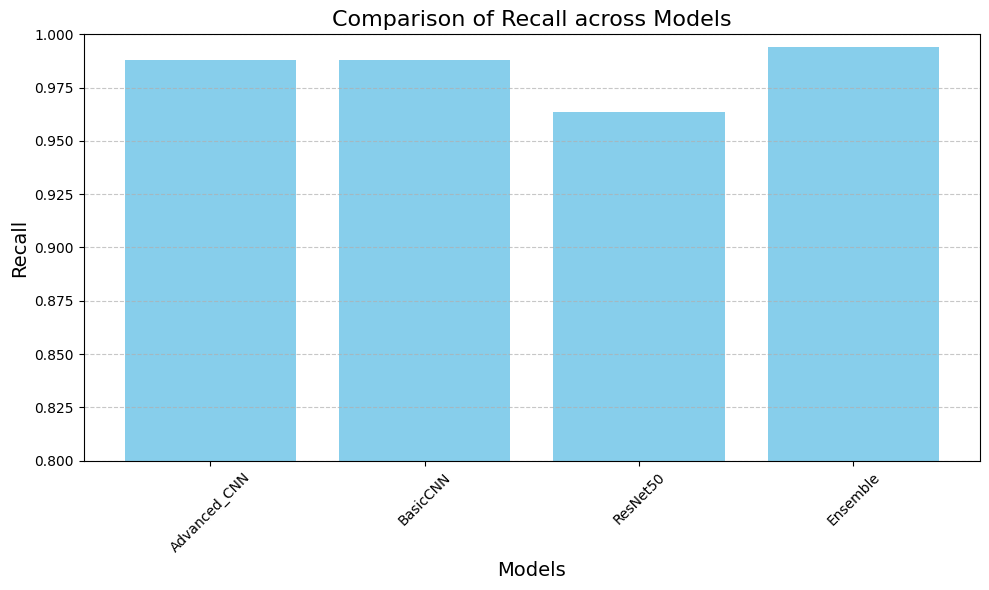

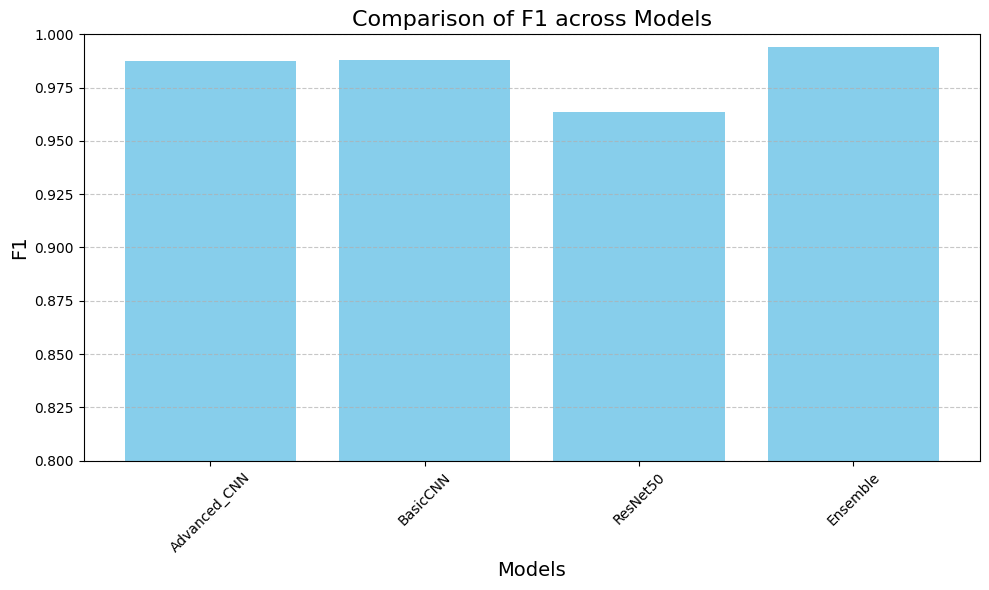

In [92]:
test_metrics["Ensemble"] = {
    "accuracy": ensemble_accuracy,
    "precision": ensemble_precision,
    "recall": ensemble_recall,
    "f1": ensemble_f1
}
metric_names = ["accuracy", "precision", "recall", "f1"]
for metric in metric_names:
    plt.figure(figsize=(10, 6))
    model_names = list(test_metrics.keys())
    metric_values = [test_metrics[m][metric] for m in model_names]

    plt.bar(model_names, metric_values, color="skyblue")
    plt.title(f"Comparison of {metric.capitalize()} across Models", fontsize=16)
    plt.xlabel("Models", fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.xticks(rotation=45)
    plt.ylim(0.8, 1.0)  # Adjust range for better visualization
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

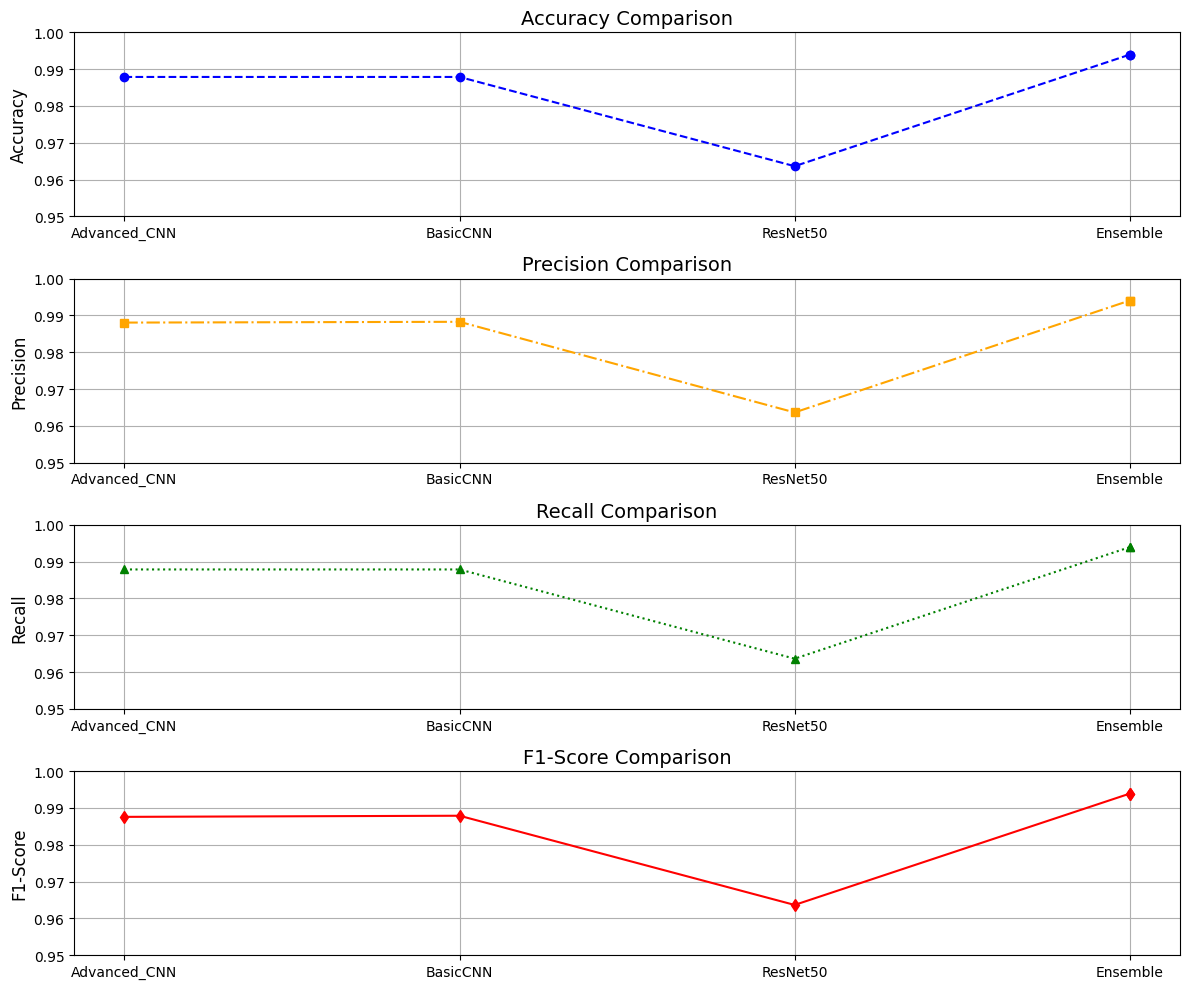

In [95]:
import matplotlib.pyplot as plt

# Extract metric values for each model
model_names = list(test_metrics.keys())
accuracies = [test_metrics[model]["accuracy"] for model in model_names]
precisions = [test_metrics[model]["precision"] for model in model_names]
recalls = [test_metrics[model]["recall"] for model in model_names]
f1_scores = [test_metrics[model]["f1"] for model in model_names]

# Add the ensemble metrics
model_names.append("Ensemble")
accuracies.append(ensemble_accuracy)
precisions.append(ensemble_precision)
recalls.append(ensemble_recall)
f1_scores.append(ensemble_f1)

plt.figure(figsize=(12, 10))

# Accuracy
plt.subplot(4, 1, 1)
plt.plot(model_names, accuracies, marker="o", linestyle="--", label="Accuracy", color="blue")
plt.title("Accuracy Comparison", fontsize=14)
plt.ylim(0.95, 1.0)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True)

# Precision
plt.subplot(4, 1, 2)
plt.plot(model_names, precisions, marker="s", linestyle="-.", label="Precision", color="orange")
plt.title("Precision Comparison", fontsize=14)
plt.ylim(0.95, 1.0)
plt.ylabel("Precision", fontsize=12)
plt.grid(True)

# Recall
plt.subplot(4, 1, 3)
plt.plot(model_names, recalls, marker="^", linestyle=":", label="Recall", color="green")
plt.title("Recall Comparison", fontsize=14)
plt.ylim(0.95, 1.0)
plt.ylabel("Recall", fontsize=12)
plt.grid(True)

# F1-Score
plt.subplot(4, 1, 4)
plt.plot(model_names, f1_scores, marker="d", linestyle="-", label="F1-Score", color="red")
plt.title("F1-Score Comparison", fontsize=14)
plt.ylim(0.95, 1.0)
plt.ylabel("F1-Score", fontsize=12)
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



In [ ]:
# Training BasicCNN...
# Epoch 1/30
# 24/24 [==============================] - 27s 1s/step - loss: 59.0800 - accuracy: 0.5958 - val_loss: 0.5839 - val_accuracy: 0.7576
# Epoch 2/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.6938 - accuracy: 0.7379 - val_loss: 0.4876 - val_accuracy: 0.8000
# Epoch 3/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.4451 - accuracy: 0.8396 - val_loss: 0.2690 - val_accuracy: 0.8788
# Epoch 4/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.1937 - accuracy: 0.9348 - val_loss: 0.1281 - val_accuracy: 0.9576
# Epoch 5/30
# 24/24 [==============================] - 25s 1s/step - loss: 0.1434 - accuracy: 0.9413 - val_loss: 0.1933 - val_accuracy: 0.9273
# Epoch 6/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.0842 - accuracy: 0.9778 - val_loss: 0.1216 - val_accuracy: 0.9636
# Epoch 7/30
# 24/24 [==============================] - 25s 1s/step - loss: 0.0514 - accuracy: 0.9857 - val_loss: 0.0967 - val_accuracy: 0.9697
# Epoch 8/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.0444 - accuracy: 0.9844 - val_loss: 0.0736 - val_accuracy: 0.9758
# Epoch 9/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.0245 - accuracy: 0.9935 - val_loss: 0.0464 - val_accuracy: 0.9697
# Epoch 10/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.0221 - accuracy: 0.9948 - val_loss: 0.0883 - val_accuracy: 0.9636
# Epoch 11/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.0214 - accuracy: 0.9935 - val_loss: 0.0328 - val_accuracy: 0.9879
# Epoch 12/30
# 24/24 [==============================] - 25s 1s/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.0636 - val_accuracy: 0.9636
# Epoch 13/30
# 24/24 [==============================] - 25s 1s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 0.9758
# Epoch 14/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0885 - val_accuracy: 0.9758
# Epoch 15/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.0154 - accuracy: 0.9974 - val_loss: 0.0758 - val_accuracy: 0.9636
# Epoch 16/30
# 24/24 [==============================] - 26s 1s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.9697
# 6/6 [==============================] - 1s 216ms/step - loss: 0.0328 - accuracy: 0.9879
# Training Advanced_CNN...
# Epoch 1/30
# 24/24 [==============================] - 88s 4s/step - loss: 32.4606 - accuracy: 0.4459 - val_loss: 0.8998 - val_accuracy: 0.5394
# Epoch 2/30
# 24/24 [==============================] - 84s 4s/step - loss: 0.8618 - accuracy: 0.6193 - val_loss: 0.6955 - val_accuracy: 0.7455
# Epoch 3/30
# 24/24 [==============================] - 86s 4s/step - loss: 0.7550 - accuracy: 0.6897 - val_loss: 0.6250 - val_accuracy: 0.7636
# Epoch 4/30
# 24/24 [==============================] - 83s 3s/step - loss: 0.5833 - accuracy: 0.7601 - val_loss: 0.4185 - val_accuracy: 0.8364
# Epoch 5/30
# 24/24 [==============================] - 80s 3s/step - loss: 0.5230 - accuracy: 0.7940 - val_loss: 0.4086 - val_accuracy: 0.8000
# Epoch 6/30
# 24/24 [==============================] - 82s 3s/step - loss: 0.4677 - accuracy: 0.8136 - val_loss: 0.3144 - val_accuracy: 0.8485
# Epoch 7/30
# 24/24 [==============================] - 83s 3s/step - loss: 0.2817 - accuracy: 0.8853 - val_loss: 0.2807 - val_accuracy: 0.8545
# Epoch 8/30
# 24/24 [==============================] - 82s 3s/step - loss: 0.2280 - accuracy: 0.9035 - val_loss: 0.2357 - val_accuracy: 0.9333
# Epoch 9/30
# 24/24 [==============================] - 82s 3s/step - loss: 0.1478 - accuracy: 0.9413 - val_loss: 0.1734 - val_accuracy: 0.9273
# Epoch 10/30
# 24/24 [==============================] - 79s 3s/step - loss: 0.0794 - accuracy: 0.9674 - val_loss: 0.0969 - val_accuracy: 0.9515
# Epoch 11/30
# 24/24 [==============================] - 82s 3s/step - loss: 0.0555 - accuracy: 0.9817 - val_loss: 0.0982 - val_accuracy: 0.9636
# Epoch 12/30
# 24/24 [==============================] - 82s 3s/step - loss: 0.0405 - accuracy: 0.9883 - val_loss: 0.0961 - val_accuracy: 0.9576
# Epoch 13/30
# 24/24 [==============================] - 81s 3s/step - loss: 0.0465 - accuracy: 0.9817 - val_loss: 0.1052 - val_accuracy: 0.9515
# Epoch 14/30
# 24/24 [==============================] - 80s 3s/step - loss: 0.0591 - accuracy: 0.9778 - val_loss: 0.0630 - val_accuracy: 0.9697
# Epoch 15/30
# 24/24 [==============================] - 81s 3s/step - loss: 0.0226 - accuracy: 0.9922 - val_loss: 0.1046 - val_accuracy: 0.9758
# Epoch 16/30
# 24/24 [==============================] - 80s 3s/step - loss: 0.0140 - accuracy: 0.9974 - val_loss: 0.1292 - val_accuracy: 0.9515
# Epoch 17/30
# 24/24 [==============================] - 80s 3s/step - loss: 0.0128 - accuracy: 0.9987 - val_loss: 0.0886 - val_accuracy: 0.9697
# Epoch 18/30
# 24/24 [==============================] - 79s 3s/step - loss: 0.0155 - accuracy: 0.9974 - val_loss: 0.1318 - val_accuracy: 0.9576
# Epoch 19/30
# 24/24 [==============================] - 78s 3s/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0564 - val_accuracy: 0.9697
# Epoch 20/30
# 24/24 [==============================] - 81s 3s/step - loss: 0.0082 - accuracy: 0.9961 - val_loss: 0.1000 - val_accuracy: 0.9636
# Epoch 21/30
# 24/24 [==============================] - 79s 3s/step - loss: 0.0067 - accuracy: 0.9974 - val_loss: 0.0652 - val_accuracy: 0.9818
# Epoch 22/30
# 24/24 [==============================] - 77s 3s/step - loss: 0.0072 - accuracy: 0.9961 - val_loss: 0.1200 - val_accuracy: 0.9697
# Epoch 23/30
# 24/24 [==============================] - 77s 3s/step - loss: 0.0179 - accuracy: 0.9961 - val_loss: 0.1471 - val_accuracy: 0.9636
# Epoch 24/30
# 24/24 [==============================] - 77s 3s/step - loss: 0.0158 - accuracy: 0.9909 - val_loss: 0.1065 - val_accuracy: 0.9697
# 6/6 [==============================] - 4s 596ms/step - loss: 0.0564 - accuracy: 0.9697